In [13]:
pip install torch torchaudio torchvision

Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.7 MB ? eta -:--:--
   ------------ --------------------------- 0.5/1.7 MB 882.6 kB/s eta 0:00:02
   ------------ --------------------------- 0.5/1.7 MB 882.6 kB/s eta 0:00:02
   ------------------ --------------------- 0.8/1.7 MB 882.6 kB/s eta 0:00:02
   ------------------------ --------------- 1.0/1.7 MB 882.6 kB/s eta 0:00:01
   ------------------------ --------------- 1.0/1.7 MB 882.6 kB/s eta 0:00:01
   ------------------------------ --------- 1.3/1.7 MB 919.0 kB/s eta 0:00:01
   ------------------------------------ --- 1.6/1.7 MB 882.6 kB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 846.0 kB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import os
import time
import random

# Third-party imports
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor # Though we are using torchaudio, this might be useful for some tensor operations or if torchvision models are adapted

In [43]:
# Dataset path - IMPORTANT: User needs to set this to their local UrbanSound8K directory
# For example: "./UrbanSound8K/" or "/path/to/your/UrbanSound8K/"
DATASET_BASE_PATH = r"E:\audio_classification\UrbanSound8K" # <<< USER SHOULD MODIFY THIS IF NECESSARY
METADATA_FILE = os.path.join(DATASET_BASE_PATH, r"metadata\UrbanSound8K.csv")
AUDIO_BASE_PATH = os.path.join(DATASET_BASE_PATH, "audio")

In [44]:
# Audio processing parameters
SAMPLE_RATE = 22050  # Sample rate for audio processing
DURATION = 4  # Duration of audio clips in seconds (UrbanSound8K clips are <= 4s)
N_MELS = 128       # Number of Mel bands
N_FFT = 2048       # FFT window size
HOP_LENGTH = 512   # Hop length for STFT
FIXED_AUDIO_LENGTH = SAMPLE_RATE * DURATION # Fixed length for audio samples (samples)

In [80]:
# Model training parameters
BATCH_SIZE = 32
NUM_EPOCHS = 8 # Adjust as needed, might take a while
LEARNING_RATE = 0.001

# For reproducibility
RANDOM_SEED = 42

In [81]:
# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


In [82]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # Ensure deterministic behavior for cuDNN (if used)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(RANDOM_SEED)

In [83]:
#if __name__ == "__main__":
    # This is where the main logic will be called.
    # For now, it's a placeholder.
print("Script initialized. Main execution block will be populated with function calls.")

    # Example: Check if metadata file exists
if not os.path.exists(METADATA_FILE):
    print(f"ERROR: Metadata file not found at {METADATA_FILE}")
    print(f"Please ensure the UrbanSound8K dataset is correctly placed and DATASET_BASE_PATH is set.")
else:
    print(f"Metadata file found at {METADATA_FILE}")

Script initialized. Main execution block will be populated with function calls.
Metadata file found at E:\audio_classification\UrbanSound8K\metadata\UrbanSound8K.csv


In [84]:
def load_metadata(metadata_path):
    """Loads the UrbanSound8K metadata.
    Args:
        metadata_path (str): Path to the metadata CSV file.
    Returns:
        pandas.DataFrame: DataFrame containing the metadata.
    """
    if not os.path.exists(metadata_path):
        raise FileNotFoundError(f"Metadata file not found: {metadata_path}")
    metadata_df = pd.read_csv(metadata_path)
    return metadata_df

In [85]:
def load_audio_file(file_path, target_sr=SAMPLE_RATE):
    """Loads an audio file using librosa.
    Args:
        file_path (str): Path to the audio file.
        target_sr (int): Target sample rate to resample to.
    Returns:
        numpy.ndarray: Audio waveform as a NumPy array.
        int: Sample rate of the loaded audio.
    """
    try:
        waveform, sr = librosa.load(file_path, sr=target_sr, mono=True)
        # Using torchaudio for consistency with PyTorch ecosystem
        waveform, sr = torchaudio.load(file_path)
        return waveform, sr
    except Exception as e:
        print(f"Error loading audio file {file_path}: {e}")
        return None, None


In [86]:
def preprocess_audio(waveform, sr, target_sr=SAMPLE_RATE, target_length=FIXED_AUDIO_LENGTH, trim_silence=True):
    """Applies preprocessing to an audio waveform.
    Args:
        waveform (torch.Tensor or np.ndarray): Input audio waveform.
        sr (int): Original sample rate of the waveform.
        target_sr (int): Target sample rate.
        target_length (int): Desired fixed length for the audio samples.
        trim_silence (bool): Whether to trim silence from the beginning and end.
    Returns:
        torch.Tensor: Preprocessed audio waveform.
    """
    # Ensure waveform is a torch tensor
    if isinstance(waveform, np.ndarray):
        waveform = torch.from_numpy(waveform).float()

    # 1. Resample if necessary
    if sr != target_sr:
        resampler = T.Resample(orig_freq=sr, new_freq=target_sr)
        waveform = resampler(waveform)
        sr = target_sr # Update sample rate

    # 2. Convert to mono (if stereo)
    if waveform.ndim > 1 and waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    # Squeeze out the channel dimension if it's 1, to make it (samples,)
    if waveform.ndim > 1 and waveform.shape[0] == 1:
         waveform = waveform.squeeze(0)

    # Convert to numpy for librosa operations like trim
    waveform_np = waveform.numpy()

    # 3. Trim silence (using librosa for this as torchaudio's VAD is more complex to setup for simple trimming)
    if trim_silence:
        # top_db=30 means consider anything 30dB below the max as silence
        waveform_trimmed, _ = librosa.effects.trim(waveform_np, top_db=30)
        if len(waveform_trimmed) == 0: # If trimming resulted in empty audio, use original
            print(f"Warning: Trimming resulted in empty audio. Using original before trim.")
        else:
            waveform_np = waveform_trimmed

    # Convert back to tensor
    waveform = torch.from_numpy(waveform_np).float()
    if waveform.ndim == 1: # Ensure it has a channel dimension for consistency (1, samples)
        waveform = waveform.unsqueeze(0)

    # 4. Normalize audio (simple peak normalization)
    # waveform = waveform / torch.max(torch.abs(waveform))
    # More robust normalization: scale to [-1, 1]
    if torch.max(torch.abs(waveform)) > 0: # Avoid division by zero for silent clips
        waveform = waveform / torch.max(torch.abs(waveform))
    else:
        waveform = torch.zeros_like(waveform) # Keep silent clips as zeros

    # 5. Pad or truncate to fixed length
    current_length = waveform.shape[1]
    if current_length > target_length:
        waveform = waveform[:, :target_length]  # Truncate
    elif current_length < target_length:
        padding = target_length - current_length
        waveform = torch.nn.functional.pad(waveform, (0, padding), mode='constant') # Pad with zeros

    return waveform.squeeze(0) # Return as (samples,) tensor


--- Testing Data Loading and Preprocessing ---
Successfully loaded metadata. Number of entries: 8732
Selected sample audio file: E:\audio_classification\UrbanSound8K\audio\fold5\100032-3-0-0.wav
Successfully loaded audio. Original SR: 44100, Shape: torch.Size([2, 14004])
Preprocessed audio. Target SR: 22050, Shape: torch.Size([88200])
Min value: -0.941916823387146, Max value: 1.0


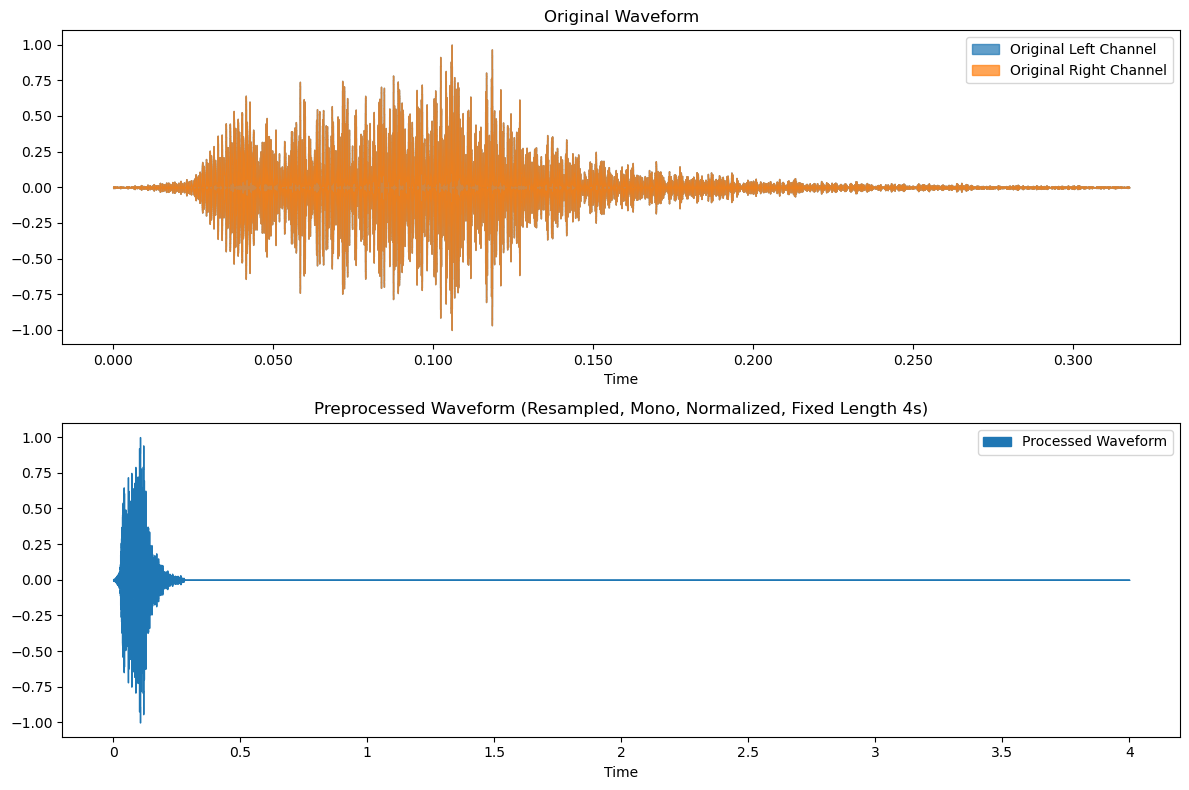

In [87]:
        
print("\n--- Testing Data Loading and Preprocessing ---")
    # Load metadata
try:
    metadata = load_metadata(METADATA_FILE)
    print(f"Successfully loaded metadata. Number of entries: {len(metadata)}")
        # print(metadata.head())

        # Select a sample audio file from metadata
    if not metadata.empty:
        sample_row = metadata.iloc[0]
        sample_filename = sample_row['slice_file_name']
        sample_fold = sample_row['fold']
        sample_path = os.path.join(AUDIO_BASE_PATH, f"fold{sample_fold}", sample_filename)
        print(f"Selected sample audio file: {sample_path}")

        if os.path.exists(sample_path):
            # Load audio file
            raw_waveform, sr = load_audio_file(sample_path)
            if raw_waveform is not None:
                print(f"Successfully loaded audio. Original SR: {sr}, Shape: {raw_waveform.shape}")

                # Preprocess audio
                processed_waveform = preprocess_audio(raw_waveform, sr, target_sr=SAMPLE_RATE, target_length=FIXED_AUDIO_LENGTH)
                print(f"Preprocessed audio. Target SR: {SAMPLE_RATE}, Shape: {processed_waveform.shape}")
                print(f"Min value: {processed_waveform.min()}, Max value: {processed_waveform.max()}")
                #Plotting for verification (optional)
                plt.figure(figsize=(12, 8))
                plt.subplot(2,1,1)
                if raw_waveform.ndim > 1 and raw_waveform.shape[0] > 1:
                    librosa.display.waveshow(raw_waveform[0].numpy(), sr=sr, alpha=0.7, label='Original Left Channel')
                    librosa.display.waveshow(raw_waveform[1].numpy(), sr=sr, alpha=0.7, label='Original Right Channel')
                elif raw_waveform.ndim > 1 and raw_waveform.shape[0] == 1:
                     librosa.display.waveshow(raw_waveform.squeeze(0).numpy(), sr=sr, label='Original Mono')
                else:
                     librosa.display.waveshow(raw_waveform.numpy(), sr=sr, label='Original Mono')                        
                plt.title("Original Waveform")
                plt.legend()
                plt.subplot(2,1,2)
                librosa.display.waveshow(processed_waveform.numpy(), sr=SAMPLE_RATE, label='Processed Waveform')
                plt.title(f"Preprocessed Waveform (Resampled, Mono, Normalized, Fixed Length {DURATION}s)")
                plt.legend()
                plt.tight_layout()
                plt.show()
            else:
                print(f"Could not load sample audio file: {sample_path}")
        else:
            print(f"Sample audio file does not exist: {sample_path}")
    else:
        print("Metadata is empty, cannot select sample audio file.")

except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f"An error occurred during testing: {e}")



In [88]:
def generate_mel_spectrogram(waveform, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS):
    """Generates a Mel spectrogram from an audio waveform using torchaudio.
    Args:
        waveform (torch.Tensor): Input audio waveform (1D tensor).
        sr (int): Sample rate of the waveform.
        n_fft (int): FFT window size.
        hop_length (int): Hop length for STFT.
        n_mels (int): Number of Mel bands.
    Returns:
        torch.Tensor: Mel spectrogram (typically [n_mels, time_frames]).
    """
    if waveform.ndim == 1:
        waveform = waveform.unsqueeze(0) # Add channel dimension if not present (1, samples)

    mel_spectrogram_transform = T.MelSpectrogram(
        sample_rate=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        power=2.0 # Power spectrogram
    )
    mel_spectrogram = mel_spectrogram_transform(waveform)

    # Convert to decibels (log scale)
    log_mel_spectrogram = T.AmplitudeToDB(stype='power', top_db=80)(mel_spectrogram)
    
    # Squeeze the channel dimension if it was added, result should be (n_mels, time_frames)
    return log_mel_spectrogram.squeeze(0)


In [89]:
class UrbanSoundDataset(Dataset):
    """Custom PyTorch Dataset for UrbanSound8K spectrograms."""
    def __init__(self, metadata_df, audio_base_path, transform_fn=None, target_sr=SAMPLE_RATE, fixed_length=FIXED_AUDIO_LENGTH, label_encoder=None):
        """
        Args:
            metadata_df (pandas.DataFrame): DataFrame containing file names, folds, and class IDs.
            audio_base_path (str): Base path to the audio folders (e.g., "./UrbanSound8K/audio/").
            transform_fn (callable, optional): A function/transform to apply to the audio data (e.g., Mel spectrogram generation).
            target_sr (int): Target sample rate for audio.
            fixed_length (int): Fixed length for audio samples.
            label_encoder (LabelEncoder, optional): Fitted LabelEncoder for class labels.
        """
        self.metadata = metadata_df.copy()  # Safe copy
        self.metadata = metadata_df
        self.audio_base_path = audio_base_path
        self.transform_fn = transform_fn
        self.target_sr = target_sr
        self.fixed_length = fixed_length
        self.label_encoder = label_encoder
        
        if self.label_encoder is None:
            self.label_encoder = LabelEncoder()
            self.metadata['class_encoded'] = self.label_encoder.fit_transform(self.metadata['classID'])
        else:
            if 'class_encoded' not in self.metadata.columns:
                self.metadata['class_encoded'] = self.label_encoder.transform(self.metadata['classID'])

        self.num_classes = len(self.label_encoder.classes_)

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.metadata.iloc[idx]
        file_name = row['slice_file_name']
        fold_num = row['fold']
        label = row['class_encoded']
        
        audio_path = os.path.join(self.audio_base_path, f"fold{fold_num}", file_name)
        
        waveform, sr = load_audio_file(audio_path, target_sr=None) # Load with original SR first
        if waveform is None: # Handle loading errors
            print(f"Warning: Could not load {audio_path}, returning zeros.")
            # Return a zero tensor of the expected spectrogram shape if transform_fn is defined
            # This is a placeholder, ideally such files should be excluded or handled robustly
            if self.transform_fn:
                # Estimate spectrogram shape: (n_mels, time_frames)
                # time_frames = (fixed_length // hop_length) + 1 (approx)
                # This is a rough estimate, actual shape depends on Mel params
                # For now, let's assume a common shape or handle it later
                # A better approach is to ensure all files load correctly or skip them.
                # For simplicity, we'll return a zero waveform and let preprocessing handle it.
                waveform = torch.zeros((1, self.fixed_length))
                sr = self.target_sr
            else:
                waveform = torch.zeros((1, self.fixed_length))
                sr = self.target_sr
        
        # Preprocess audio (resample, mono, normalize, pad/truncate)
        processed_waveform = preprocess_audio(waveform, sr, target_sr=self.target_sr, target_length=self.fixed_length)

        if self.transform_fn:
            # Apply the transformation (e.g., generate Mel spectrogram)
            transformed_data = self.transform_fn(processed_waveform, sr=self.target_sr)
        else:
            transformed_data = processed_waveform # Return waveform if no transform

        # Ensure the spectrogram has a channel dimension (C, H, W) for CNN
        if transformed_data.ndim == 2: # (n_mels, time_frames)
            transformed_data = transformed_data.unsqueeze(0) # (1, n_mels, time_frames)

        return transformed_data, torch.tensor(label, dtype=torch.long)



--- Testing Mel Spectrogram Generation and Dataset ---
Generated Mel spectrogram. Shape: torch.Size([128, 173])


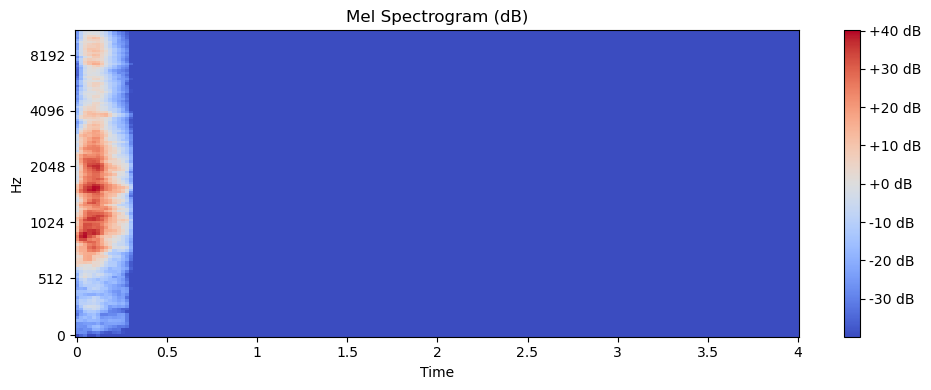

Classes found by LabelEncoder: [0 1 2 3 4 5 6 7 8 9]
Created UrbanSoundDataset with 10 samples.
Sample from dataset - Spectrogram shape: torch.Size([1, 128, 173]), Label: 8
Batch from DataLoader - Spectrograms shape: torch.Size([4, 1, 128, 173]), Labels shape: torch.Size([4])


In [90]:

        
print("\n--- Testing Mel Spectrogram Generation and Dataset ---")
    # Assuming metadata is loaded and sample audio processed from previous test block
try:
    metadata = load_metadata(METADATA_FILE)
    if not metadata.empty:
        sample_row = metadata.iloc[0]
        sample_filename = sample_row['slice_file_name']
        sample_fold = sample_row['fold']
        sample_path = os.path.join(AUDIO_BASE_PATH, f"fold{sample_fold}", sample_filename)

        if os.path.exists(sample_path):
            raw_waveform, sr = load_audio_file(sample_path)
            if raw_waveform is not None:
                processed_waveform = preprocess_audio(raw_waveform, sr, target_sr=SAMPLE_RATE, target_length=FIXED_AUDIO_LENGTH)
                    
                    # Generate Mel spectrogram
                mel_spec = generate_mel_spectrogram(processed_waveform, sr=SAMPLE_RATE)
                print(f"Generated Mel spectrogram. Shape: {mel_spec.shape}") # Expected: (N_MELS, time_frames)

                    # Plotting Mel Spectrogram (optional)
                plt.figure(figsize=(10, 4))
                librosa.display.specshow(mel_spec.numpy(), sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
                plt.colorbar(format='%+2.0f dB')
                plt.title('Mel Spectrogram (dB)')
                plt.tight_layout()
                plt.show()

                    # Test UrbanSoundDataset
                    # For testing, use a small subset of the data
                    # In practice, you'd split the full dataset
                test_metadata_subset = metadata.sample(n=10, random_state=RANDOM_SEED) 
                    
                    # Initialize LabelEncoder on the full dataset's classes to ensure all classes are known
                le = LabelEncoder()
                le.fit(metadata['classID'])
                print(f"Classes found by LabelEncoder: {le.classes_}")

                    # Pass the fitted LabelEncoder to the dataset
                    # And pass the generate_mel_spectrogram function as the transform
                test_dataset = UrbanSoundDataset(metadata_df=test_metadata_subset, 
                                             audio_base_path=AUDIO_BASE_PATH, 
                                             transform_fn=generate_mel_spectrogram, 
                                             label_encoder=le)
                    
                print(f"Created UrbanSoundDataset with {len(test_dataset)} samples.")
                if len(test_dataset) > 0:
                    sample_spec, sample_label = test_dataset[0]
                    print(f"Sample from dataset - Spectrogram shape: {sample_spec.shape}, Label: {sample_label}")
                    # Expected shape: (1, N_MELS, time_frames) due to unsqueeze for channel

                        # Test DataLoader
                    test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)
                    for batch_specs, batch_labels in test_dataloader:
                        print(f"Batch from DataLoader - Spectrograms shape: {batch_specs.shape}, Labels shape: {batch_labels.shape}")
                        # Expected shape: (batch_size, 1, N_MELS, time_frames)
                        break # Just check one batch
        else:
            print(f"Sample audio file for testing spectrograms does not exist: {sample_path}")
    else:
        print("Metadata is empty, cannot test spectrogram generation.")

except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f"An error occurred during spectrogram/dataset testing: {e}")



In [91]:
def prepare_dataloaders(metadata_path, audio_path, batch_size=BATCH_SIZE, test_fold=10):
    """Prepares training and validation DataLoaders.
    Args:
        metadata_path (str): Path to the metadata CSV file.
        audio_path (str): Base path to audio folders.
        batch_size (int): Batch size for DataLoaders.
        test_fold (int): Fold number to use for validation/testing.
    Returns:
        torch.utils.data.DataLoader: Training DataLoader.
        torch.utils.data.DataLoader: Validation DataLoader.
        LabelEncoder: Fitted LabelEncoder.
        int: Number of classes.
    """
    
    metadata_df = load_metadata(metadata_path)
    
    # Initialize and fit LabelEncoder on the 'classID' column from the full dataset
    label_encoder = LabelEncoder()
    metadata_df['class_encoded'] = label_encoder.fit_transform(metadata_df['classID'])
    num_classes = len(label_encoder.classes_)
    print(f"Total classes: {num_classes}, Labels: {list(label_encoder.classes_)}")

    # Split data based on folds
    # Folds are 1-indexed in the CSV
    train_df = metadata_df[metadata_df['fold'] != test_fold]
    val_df = metadata_df[metadata_df['fold'] == test_fold]
    
    # Reduce data size for debugging
    train_df = train_df.sample(n=2800, random_state=42)  
    val_df = val_df.sample(n=700, random_state=42) 

    print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

    # Create Datasets
    # Pass the already fitted label_encoder to both datasets
    train_dataset = UrbanSoundDataset(metadata_df=train_df, 
                                      audio_base_path=audio_path, 
                                      transform_fn=generate_mel_spectrogram,
                                      label_encoder=label_encoder)
    
    val_dataset = UrbanSoundDataset(metadata_df=val_df, 
                                    audio_base_path=audio_path, 
                                    transform_fn=generate_mel_spectrogram,
                                    label_encoder=label_encoder)
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True if DEVICE == 'cuda' else False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True if DEVICE == 'cuda' else False)

    return train_loader, val_loader, label_encoder, num_classes


In [92]:

print("\n--- Testing DataLoader Preparation ---")
try:
    # Check if metadata file exists before proceeding
    if not os.path.exists(METADATA_FILE):
        print(f"ERROR: Metadata file not found at {METADATA_FILE}. Cannot prepare DataLoaders.")
        print(f"Please ensure the UrbanSound8K dataset is correctly placed and DATASET_BASE_PATH is set.")
    else:
        train_loader, val_loader, le, n_classes = prepare_dataloaders(METADATA_FILE, AUDIO_BASE_PATH)
        print(f"DataLoaders prepared. Number of classes: {n_classes}")
        print(f"Training DataLoader: {len(train_loader.dataset)} samples, {len(train_loader)} batches")
        print(f"Validation DataLoader: {len(val_loader.dataset)} samples, {len(val_loader)} batches")

            # Inspect a batch (optional)
            # for specs, labels in train_loader:
            #     print(f"Train batch - Spectrograms shape: {specs.shape}, Labels: {labels[:5]}...")
            #     break
            # for specs, labels in val_loader:
            #     print(f"Validation batch - Spectrograms shape: {specs.shape}, Labels: {labels[:5]}...")
            #     break
except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f"An error occurred during DataLoader preparation testing: {e}")


--- Testing DataLoader Preparation ---
Total classes: 10, Labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Training samples: 2800, Validation samples: 700
DataLoaders prepared. Number of classes: 10
Training DataLoader: 2800 samples, 88 batches
Validation DataLoader: 700 samples, 22 batches


In [93]:
print(train_loader.dataset)

In [94]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes, input_shape):
        """
        Args:
            num_classes (int): Number of output classes.
            input_shape (tuple): Shape of the input spectrogram (channels, height, width) e.g. (1, N_MELS, time_frames)
        """
        super(SimpleCNN, self).__init__()
        # Input shape: (batch_size, 1, N_MELS, time_frames)
        # Example: (32, 1, 128, 173) if DURATION=4s, SR=22050, HOP_LENGTH=512
        # N_MELS = 128
        # time_frames = (FIXED_AUDIO_LENGTH // HOP_LENGTH) + 1 = (88200 // 512) + 1 = 172 + 1 = 173
        
        # For dynamic input size, we can calculate the flattened size after conv layers
        # Or use AdaptiveAvgPool2d before the fully connected layer.
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[0], out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Output shape: (batch_size, 16, N_MELS/2, time_frames/2)
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Output shape: (batch_size, 32, N_MELS/4, time_frames/4)
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Output shape: (batch_size, 64, N_MELS/8, time_frames/8)

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # Output shape: (batch_size, 128, N_MELS/16, time_frames/16)
        )
        
        # Calculate the flattened size dynamically
        # Create a dummy input with the specified input shape
        with torch.no_grad():
            dummy_input = torch.randn(1, *input_shape) # (1, C, H, W)
            dummy_output = self.conv_layers(dummy_input)
            self.flattened_size = dummy_output.view(1, -1).size(1)

        self.fc_layers = nn.Sequential(
            nn.Linear(self.flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1) # Flatten the output for the fully connected layer
        x = self.fc_layers(x)
        return x


In [95]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS, device=DEVICE, model_save_path="./best_sound_classifier.pth"):
    """Trains the model and validates it after each epoch.
    Args:
        model (torch.nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        criterion (torch.nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer.
        num_epochs (int): Number of epochs to train for.
        device (torch.device): Device to train on (CPU or CUDA).
        model_save_path (str): Path to save the best model.
    Returns:
        list: Training losses per epoch.
        list: Training accuracies per epoch.
        list: Validation losses per epoch.
        list: Validation accuracies per epoch.
        str: Path to the saved best model.
    """
    model.to(device)
    
    best_val_accuracy = 0.0
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    print(f"Starting training for {num_epochs} epochs on {device}...")

    for epoch in range(num_epochs):
        start_time = time.time()
        # --- Training Phase ---
        model.train() # Set model to training mode
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad() # Zero the parameter gradients
            
            outputs = model(inputs) # Forward pass
            loss = criterion(outputs, labels) # Calculate loss
            
            loss.backward() # Backward pass
            optimizer.step() # Optimize
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
            if (batch_idx + 1) % 100 == 0: # Print progress every 100 batches
                print(f"  Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}")

        epoch_train_loss = running_loss / total_samples
        epoch_train_accuracy = correct_predictions / total_samples
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # --- Validation Phase ---
        model.eval() # Set model to evaluation mode
        running_val_loss = 0.0
        correct_val_predictions = 0
        total_val_samples = 0
        
        with torch.no_grad(): # No gradients needed for validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val_samples += labels.size(0)
                correct_val_predictions += (predicted == labels).sum().item()
        
        epoch_val_loss = running_val_loss / total_val_samples
        epoch_val_accuracy = correct_val_predictions / total_val_samples
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)
        
        end_time = time.time()
        epoch_duration = end_time - start_time

        print(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_duration:.2f}s: ")
        print(f"  Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}")
        print(f"  Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

        # Save the model if validation accuracy has improved
        if epoch_val_accuracy > best_val_accuracy:
            best_val_accuracy = epoch_val_accuracy
            torch.save(model.state_dict(), model_save_path)
            print(f"  Best model saved to {model_save_path} (Val Accuracy: {best_val_accuracy:.4f})")
            
    print("Training finished.")
    return train_losses, train_accuracies, val_losses, val_accuracies, model_save_path


In [96]:
print("\n--- Model Training and Validation ---")
    # This block will be executed only when the script is run directly.
    # Ensure DataLoaders are prepared first.
    
    # Check if metadata file exists to avoid errors if run partially
if not os.path.exists(METADATA_FILE):
    print(f"ERROR: Metadata file not found at {METADATA_FILE}. Cannot proceed with training.")
    print(f"Please ensure the UrbanSound8K dataset is correctly placed and DATASET_BASE_PATH is set.")
else:
        # 1. Prepare DataLoaders
    try:
        train_loader, val_loader, label_encoder, num_classes = prepare_dataloaders(METADATA_FILE, AUDIO_BASE_PATH, BATCH_SIZE, test_fold=10)
        print(f"DataLoaders ready. Number of classes: {num_classes}")

            # 2. Determine input shape for the model from a sample batch
            # This is crucial for the CNN architecture
        sample_batch_spec, _ = next(iter(train_loader))
        input_c, input_h, input_w = sample_batch_spec.shape[1], sample_batch_spec.shape[2], sample_batch_spec.shape[3]
        cnn_input_shape = (input_c, input_h, input_w) # (channels, N_MELS, time_frames)
        print(f"Determined CNN input shape: {cnn_input_shape}")

            # 3. Initialize Model, Loss, Optimizer
        model = SimpleCNN(num_classes=num_classes, input_shape=cnn_input_shape)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
          
        print(f"Model initialized: {model.__class__.__name__}")
        # print(model) # Optionally print model summary

            # 4. Train the model
            # Reduce NUM_EPOCHS for a quick test run if needed, e.g., NUM_EPOCHS = 5
            # For actual training, use the configured NUM_EPOCHS (e.g., 50)
            # Make sure to define a path for the saved model
        saved_model_filename = "urban_sound_cnn_pytorch.pth"
        saved_model_path = os.path.join(".", saved_model_filename) # Save in current directory

            # Check if a pre-trained model exists and if user wants to skip training
            # For this script, we will always train, but this is a common pattern:
        if os.path.exists(saved_model_path):
            print(f"Found existing model at {saved_model_path}. Skipping training.")
                # model.load_state_dict(torch.load(saved_model_path, map_location=DEVICE))
        else:
            print(f"No pre-trained model found at {saved_model_path}. Starting training...")
            
            # For this script, we always train. If you want to load a pre-trained model, 
            # you would load its state_dict here and skip the train_model call.
            
        history = train_model(model, train_loader, val_loader, criterion, optimizer, 
                              num_epochs=NUM_EPOCHS, device=DEVICE, model_save_path=saved_model_path)
            
        train_l, train_a, val_l, val_a, best_model_file = history
        print(f"Training complete. Best model saved at: {best_model_file}")

    except FileNotFoundError as e:
        print(f"File not found error during training setup: {e}")
    except Exception as e:
        print(f"An error occurred during model training and validation: {e}")
        import traceback
        traceback.print_exc()


--- Model Training and Validation ---
Total classes: 10, Labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Training samples: 2800, Validation samples: 700
DataLoaders ready. Number of classes: 10
Determined CNN input shape: (1, 128, 173)
Model initialized: SimpleCNN
Found existing model at .\urban_sound_cnn_pytorch.pth. Skipping training.
Starting training for 8 epochs on cpu...
Epoch [1/8] completed in 101.93s: 
  Train Loss: 1.7512, Train Accuracy: 0.3607
  Val Loss: 1.4552, Val Accuracy: 0.4557
  Best model saved to .\urban_sound_cnn_pytorch.pth (Val Accuracy: 0.4557)
Epoch [2/8] completed in 106.23s: 
  Train Loss: 1.2123, Train Accuracy: 0.5686
  Val Loss: 1.3636, Val Accuracy: 0.5743
  Best model saved to .\urban_sound_cnn_pytorch.pth (Val Accuracy: 0.5743)
Epoch [3/8] completed in 104.82s: 
  Train Loss: 0.8749, Train Accuracy: 0.6943
  Val Loss: 1.1748, Val Accuracy: 0.6386
  Best model saved to .\urban_sound_cnn_pytorch.pth (Val Accuracy: 0.6386)
Epoch [4/8] completed in 102.06s: 
  Tra

In [97]:
def plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies):
    """Plots the training and validation loss and accuracy.
    Args:
        train_losses (list): List of training losses per epoch.
        train_accuracies (list): List of training accuracies per epoch.
        val_losses (list): List of validation losses per epoch.
        val_accuracies (list): List of validation accuracies per epoch.
    """
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs. Epochs')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs. Epochs')
    plt.grid(True)

    plt.tight_layout()
    plt.show() # In a script, you might want to save this figure instead of showing
    #plt.savefig(\'training_history.png
    #print("Training history plot saved as training_history.png")


In [98]:
from sklearn.utils.multiclass import unique_labels

def evaluate_model(model, data_loader, criterion, device, label_encoder):
    """Evaluates the model on the given data loader.
    Args:
        model (torch.nn.Module): The trained model.
        data_loader (DataLoader): DataLoader for evaluation data.
        criterion (torch.nn.Module): Loss function.
        device (torch.device): Device to evaluate on (CPU or CUDA).
        label_encoder (LabelEncoder): Fitted LabelEncoder to get class names.
    Returns:
        float: Evaluation loss.
        float: Evaluation accuracy.
        list: True labels.
        list: Predicted labels.
    """
    model.to(device)
    model.eval() # Set model to evaluation mode
    
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    all_true_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())
            
    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    
    print(f"Evaluation Results:")
    print(f"  Average Loss: {avg_loss:.4f}")
    print(f"  Accuracy: {accuracy:.4f} ({correct_predictions}/{total_samples})")
    
    # Classification Report
    class_names = label_encoder.classes_
    print("\nClassification Report:")
    # Ensure target_names are strings if they are not already
    class_names_str = [str(cn) for cn in class_names]
    all_possible_labels = list(range(len(class_names_str)))  # e.g., [0, 1, ..., 9]
    report = classification_report(all_true_labels, all_predicted_labels, labels=all_possible_labels, target_names=class_names_str, zero_division=0)
    print(report)
    
    return avg_loss, accuracy, all_true_labels, all_predicted_labels


In [99]:
def plot_confusion_matrix(true_labels, predicted_labels, class_names, save_path="confusion_matrix.png"):
    """Plots and saves the confusion matrix.
    Args:
        true_labels (list or np.array): Ground truth labels.
        predicted_labels (list or np.array): Predicted labels.
        class_names (list): List of class names for axis ticks.
        save_path (str): Path to save the confusion matrix image.
    """
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    # Use a sequential colormap that is good for heatmaps, like 'viridis' or 'Blues'
    # For confusion matrices, a diverging map might not be ideal unless comparing to a baseline.
    # 'Blues' is often used for confusion matrices.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha="right")
    plt.yticks(tick_marks, class_names)
    
    # Add text annotations for clarity
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j],'d'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    # plt.show()
    plt.savefig(save_path)
    print(f"Confusion matrix saved as {save_path}")


--- Model Evaluation ---
Total classes: 10, Labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Training samples: 2800, Validation samples: 700
Validation DataLoader for evaluation is ready.
CNN input shape for evaluation model: (1, 128, 173)
Loading model weights from: .\urban_sound_cnn_pytorch.pth
Model weights loaded successfully.


127.0.0.1 - - [19/May/2025 12:12:07] "POST /upload HTTP/1.1" 200 -


Evaluation Results:
  Average Loss: 1.1257
  Accuracy: 0.7257 (508/700)

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.67      0.73        81
           1       0.76      0.93      0.84        28
           2       0.59      0.69      0.64        88
           3       0.80      0.69      0.74        83
           4       0.66      0.61      0.63        84
           5       0.66      0.81      0.72        78
           6       1.00      1.00      1.00        27
           7       0.84      0.92      0.88        77
           8       0.78      0.36      0.50        69
           9       0.68      0.86      0.76        85

    accuracy                           0.73       700
   macro avg       0.76      0.75      0.74       700
weighted avg       0.74      0.73      0.72       700

Confusion matrix saved as confusion_matrix.png

Plotting training history...


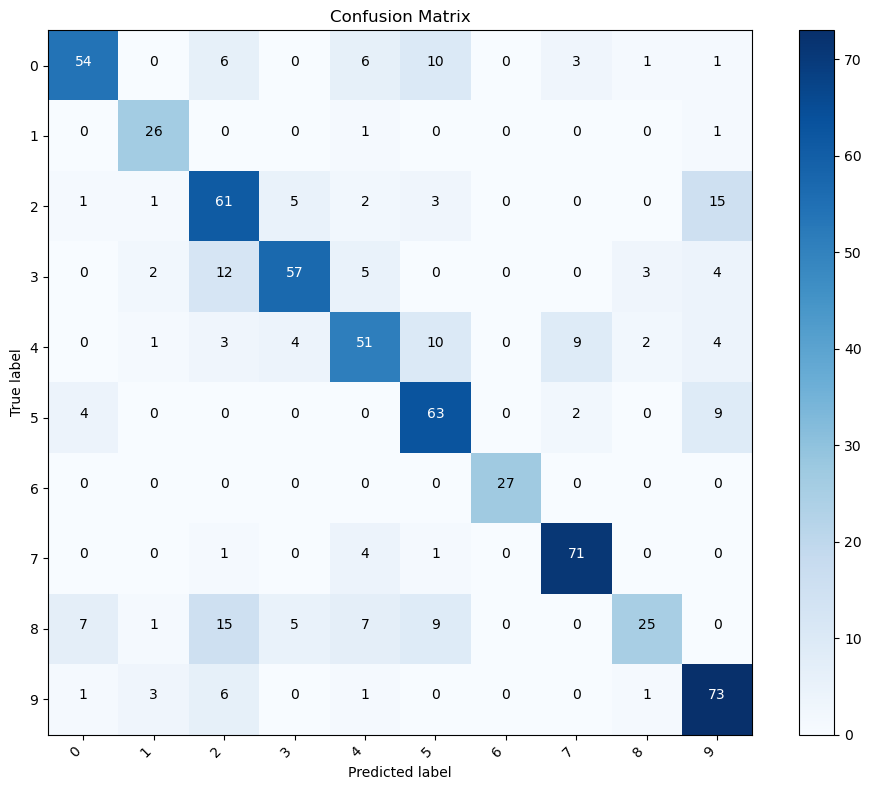

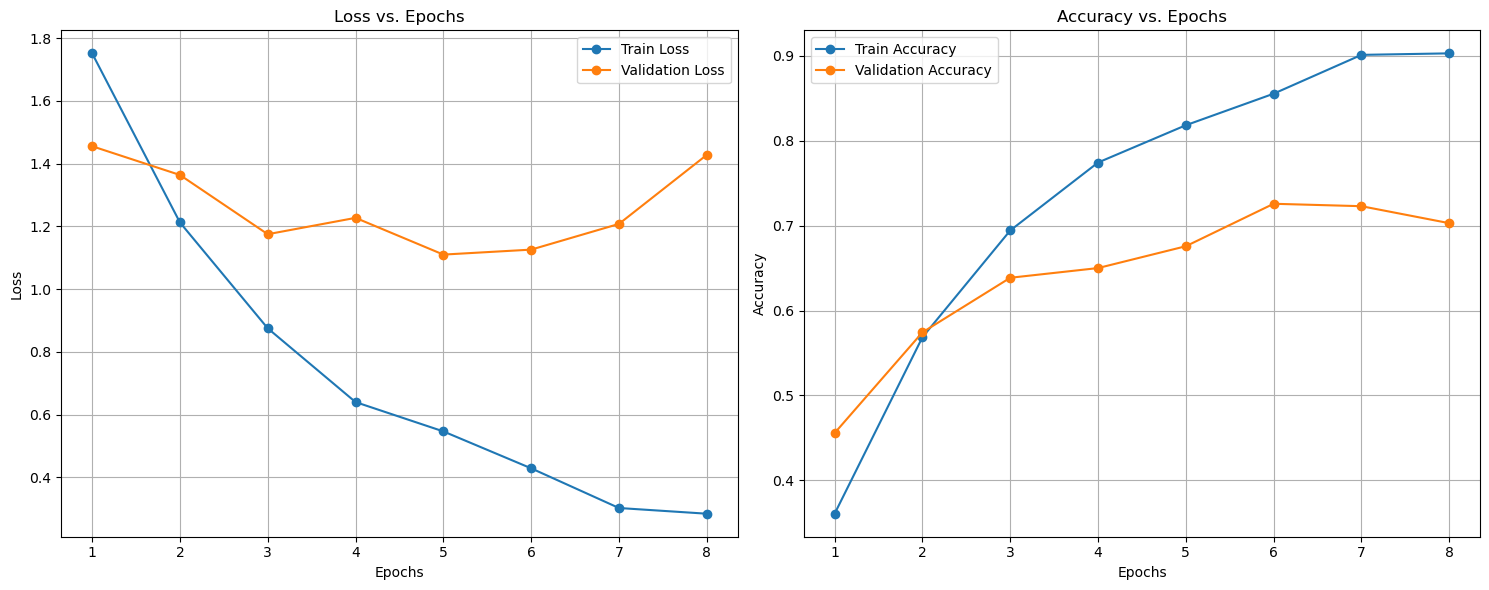

In [100]:

print("\n--- Model Evaluation ---")
# This block assumes training has been completed and the best model is saved.
# It also assumes DataLoaders and label_encoder are available from the training phase.

    # Check if metadata file exists to avoid errors if run partially
if not os.path.exists(METADATA_FILE):
    print(f"ERROR: Metadata file not found at {METADATA_FILE}. Cannot proceed with evaluation.")
else:
        # Re-use or re-initialize components needed for evaluation
        # If running this script top-to-bottom, these would be in memory.
        # If running evaluation separately, you might need to reload them.
    try:
            # 1. Prepare DataLoaders (especially val_loader for evaluation)
            # We need label_encoder and num_classes from here.
            # Use the same test_fold as during training for consistency.
            # If train_loader is not needed, it can be assigned to _
        _, val_loader_eval, label_encoder_eval, num_classes_eval = prepare_dataloaders(
            METADATA_FILE, AUDIO_BASE_PATH, BATCH_SIZE, test_fold=10
        )
        print("Validation DataLoader for evaluation is ready.")

            # 2. Determine input shape for the model (if not already known)
            # This is needed to initialize the model structure before loading weights
        sample_batch_spec_eval, _ = next(iter(val_loader_eval))
        input_c_eval, input_h_eval, input_w_eval = sample_batch_spec_eval.shape[1], sample_batch_spec_eval.shape[2], sample_batch_spec_eval.shape[3]
        cnn_input_shape_eval = (input_c_eval, input_h_eval, input_w_eval)
        print(f"CNN input shape for evaluation model: {cnn_input_shape_eval}")

            # 3. Initialize the model structure
        evaluation_model = SimpleCNN(num_classes=num_classes_eval, input_shape=cnn_input_shape_eval)
            
            # 4. Load the saved best model weights
        saved_model_filename = "urban_sound_cnn_pytorch.pth"
        model_path_to_load = os.path.join(".", saved_model_filename)
            
        if os.path.exists(model_path_to_load):
            print(f"Loading model weights from: {model_path_to_load}")
            # Load weights, ensuring map_location is set for device compatibility
            evaluation_model.load_state_dict(torch.load(model_path_to_load, map_location=DEVICE))
            evaluation_model.to(DEVICE) # Move model to device
            print("Model weights loaded successfully.")

                # 5. Define criterion (needed for loss calculation during evaluation)
            criterion_eval = nn.CrossEntropyLoss()

                # 6. Evaluate the model
            eval_loss, eval_accuracy, true_labels, pred_labels = evaluate_model(
                evaluation_model, val_loader_eval, criterion_eval, DEVICE, label_encoder_eval
            )
                
                # 7. Plot confusion matrix
            plot_confusion_matrix(true_labels, pred_labels, label_encoder_eval.classes_)

                # 8. Plot training history (if history was captured from training)
                # This part assumes `history` (train_l, train_a, val_l, val_a) is available.
                # If running evaluation separately, you might need to load these from a file or skip.
                # For this script, if `train_model` was run, `history` would be in scope.
                # We will try to access it, but handle if it's not defined (e.g. if only evaluation part is run)
            try:
                    # Check if history variables from training are defined
                if 'train_l' in locals() and 'train_a' in locals() and 'val_l' in locals() and 'val_a' in locals():
                    print("\nPlotting training history...")
                    plot_training_history(train_l, train_a, val_l, val_a)
                elif 'history' in locals() and len(history) == 5:
                     # if history tuple is available
                    train_l_hist, train_a_hist, val_l_hist, val_a_hist, _ = history
                    print("\nPlotting training history from history tuple...")
                    plot_training_history(train_l_hist, train_a_hist, val_l_hist, val_a_hist)
                else:
                    print("Training history data not found. Skipping history plot.")
                    print("To see the training history plot, run the training section before evaluation or load history data.")
            except NameError:
                print("Training history data not available (NameError). Skipping history plot.")
            except Exception as e_hist:
                print(f"Could not plot training history: {e_hist}")

        else:
            print(f"ERROR: Saved model file not found at {model_path_to_load}. Cannot evaluate.")
            print("Please train the model first using the training section of this script.")

    except FileNotFoundError as e:
        print(f"File not found error during evaluation setup: {e}")
    except Exception as e:
        print(f"An error occurred during model evaluation: {e}")
        import traceback
        traceback.print_exc()





In [101]:
def predict_sound_class(audio_file_path, model_path, label_encoder, device, 
                        target_sr=SAMPLE_RATE, fixed_length=FIXED_AUDIO_LENGTH, 
                        n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH):
    """Predicts the sound class of a given audio file.
    Args:
        audio_file_path (str): Path to the audio file.
        model_path (str): Path to the trained model (.pth file).
        label_encoder (LabelEncoder): Fitted LabelEncoder used during training.
        device (torch.device): Device to run prediction on (CPU or CUDA).
        target_sr (int): Target sample rate.
        fixed_length (int): Fixed audio length in samples.
        n_mels (int): Number of Mel bands for spectrogram.
        n_fft (int): FFT window size for spectrogram.
        hop_length (int): Hop length for spectrogram.
    Returns:
        str: Predicted class name. Returns None if prediction fails.
    """
    if not os.path.exists(audio_file_path):
        print(f"Error: Audio file not found at {audio_file_path}")
        return None
    if not os.path.exists(model_path):
        print(f"Error: Model file not found at {model_path}")
        return None

    try:
        # 1. Load and preprocess audio
        waveform, sr = load_audio_file(audio_file_path, target_sr=None) # Load with original SR
        if waveform is None:
            return None
        
        processed_waveform = preprocess_audio(waveform, sr, target_sr=target_sr, target_length=fixed_length)
        
        # 2. Generate Mel spectrogram
        mel_spectrogram = generate_mel_spectrogram(processed_waveform, sr=target_sr, 
                                                 n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        
        # 3. Prepare spectrogram for model (add batch and channel dimensions)
        # Expected input shape for CNN: (batch_size, channels, height, width)
        # Here, batch_size=1, channels=1 (mono spectrogram)
        # mel_spectrogram shape is (n_mels, time_frames)
        spectrogram_batch = mel_spectrogram.unsqueeze(0).unsqueeze(0).to(device) # Becomes (1, 1, n_mels, time_frames)

        # 4. Load the trained model
        num_classes = len(label_encoder.classes_)
        # The input shape for the model is (channels, height, width)
        # From spectrogram_batch: (1, 1, n_mels, time_frames), so input_shape is (1, n_mels, time_frames)
        model_input_shape = (spectrogram_batch.shape[1], spectrogram_batch.shape[2], spectrogram_batch.shape[3])
        
        model = SimpleCNN(num_classes=num_classes, input_shape=model_input_shape)
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        model.eval() # Set model to evaluation mode

        # 5. Make prediction
        with torch.no_grad():
            outputs = model(spectrogram_batch)
            _, predicted_idx = torch.max(outputs.data, 1)
            predicted_class_idx = predicted_idx.item()
        
        # 6. Convert predicted index to class label
        predicted_label = label_encoder.inverse_transform([predicted_class_idx])[0]
        
        return predicted_label

    except Exception as e:
        print(f"Error during prediction for {audio_file_path}: {e}")
        import traceback
        traceback.print_exc()
        return None

In [111]:
if __name__ == "__main__":
    print("\n--- Prediction on a New Audio File ---")
    # This block demonstrates how to use the prediction function.
    # It assumes the model has been trained and saved, and label_encoder is available.

    # Check if metadata file exists (as a proxy for dataset availability for picking a sample)
    if not os.path.exists(METADATA_FILE):
        print(f"ERROR: Metadata file not found at {METADATA_FILE}. Cannot run prediction example.")
    else:
        try:
            # Paths and objects needed for prediction:
            # 1. Path to the trained model
            trained_model_path = os.path.join(".", "urban_sound_cnn_pytorch.pth")
            if not os.path.exists(trained_model_path):
                print(f"Trained model not found at {trained_model_path}. Please train the model first.")
            else:
                # 2. Fitted LabelEncoder
                # We need to get the label_encoder that was fitted on the training data.
                # If running the script sequentially, `label_encoder_eval` or `le` from training/evaluation might be in scope.
                # For a robust standalone prediction, it's better to save/load the LabelEncoder or re-fit it.
                # Here, we try to re-initialize it like in `prepare_dataloaders` for consistency.
                temp_metadata = load_metadata(METADATA_FILE)
                le_for_prediction = LabelEncoder()
                le_for_prediction.fit(temp_metadata["classID"])
                print(f"LabelEncoder for prediction initialized. Classes: {list(le_for_prediction.classes_)}")

                # 3. Path to a sample audio file for prediction
                # User should replace this with the path to their own audio file.
                # For this example, let's try to pick one from the dataset (e.g., from fold 10, the validation set)
                val_metadata = temp_metadata[temp_metadata["fold"] == 10]
                if not val_metadata.empty:
                    sample_audio_row = val_metadata.sample(1, random_state=RANDOM_SEED).iloc[0]
                    sample_audio_filename = sample_audio_row["slice_file_name"]
                    sample_audio_fold = sample_audio_row["fold"]
                    example_audio_path = os.path.join(AUDIO_BASE_PATH, f"fold{sample_audio_fold}", sample_audio_filename)
                    actual_class = sample_audio_row["class"]
                    print(f"\nUsing sample audio file for prediction: {example_audio_path}")
                    print(f"Actual class of sample audio: {actual_class}")

                    if os.path.exists(example_audio_path):
                        # Make prediction
                        predicted_sound = predict_sound_class(example_audio_path, 
                                                              trained_model_path, 
                                                              le_for_prediction, 
                                                              DEVICE)
                        
                        if predicted_sound:
                            print(f"Predicted sound class: {predicted_sound}")
                        else:
                            print("Prediction failed for the sample audio file.")
                    else:
                        print(f"Sample audio file for prediction not found: {example_audio_path}")
                else:
                    print("Could not find a sample audio file from fold 10 for prediction example.")
                    print("Please provide a path to an audio file for `example_audio_path`.")

                # Example with a placeholder for user to test their own file:
                # user_audio_file = "/path/to/your/audio/file.wav" # <<< USER: REPLACE THIS
                # if os.path.exists(user_audio_file):
                #     predicted_user_sound = predict_sound_class(user_audio_file, trained_model_path, le_for_prediction, DEVICE)
                #     if predicted_user_sound:
                #         print(f"Predicted sound class for {user_audio_file}: {predicted_user_sound}")
                # else:
                #     print(f"User audio file {user_audio_file} not found. Skipping user file prediction.")

        except FileNotFoundError as e:
            print(f"File not found error during prediction setup: {e}")
        except Exception as e:
            print(f"An error occurred during prediction example: {e}")
            import traceback
            traceback.print_exc()



--- Prediction on a New Audio File ---
LabelEncoder for prediction initialized. Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Using sample audio file for prediction: E:\audio_classification\UrbanSound8K\audio\fold10\157207-6-9-0.wav
Actual class of sample audio: gun_shot
Predicted sound class: 6


127.0.0.1 - - [19/May/2025 12:25:24] "POST /upload HTTP/1.1" 200 -
127.0.0.1 - - [19/May/2025 12:25:41] "POST /upload HTTP/1.1" 200 -
127.0.0.1 - - [19/May/2025 12:26:04] "POST /upload HTTP/1.1" 200 -
127.0.0.1 - - [19/May/2025 12:26:21] "POST /upload HTTP/1.1" 200 -


In [115]:
"""
Environmental Sound Classifier - Flask Implementation

"""

import os
import io
import base64
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
import torchvision.models as models
import librosa
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from flask import Flask, request, jsonify
from werkzeug.utils import secure_filename
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import time

# Constants for audio processing
SAMPLE_RATE = 22050
DURATION = 4
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
FIXED_AUDIO_LENGTH = SAMPLE_RATE * DURATION

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Class labels
CLASS_LABELS = [
    "air_conditioner", "car_horn", "children_playing", "dog_bark",
    "drilling", "engine_idling", "gun_shot", "jackhammer",
    "siren", "street_music"
]

#######################
# DATA AUGMENTATION
#######################

def time_shift(waveform, shift_limit=0.3):
    """Apply random time shift to waveform"""
    if waveform.ndim > 1:  # Handle multi-channel audio
        length = waveform.shape[1]
        shift = int(random.random() * shift_limit * length)
        direction = random.choice([-1, 1])
        shifted = torch.roll(waveform, shift * direction, dims=1)
    else:  # Handle single-channel audio
        length = waveform.shape[0]
        shift = int(random.random() * shift_limit * length)
        direction = random.choice([-1, 1])
        shifted = torch.roll(waveform, shift * direction)
    return shifted

def pitch_shift(waveform, sr, n_steps=4):
    """Apply pitch shifting"""
    # Convert to numpy for librosa
    if waveform.ndim > 1:  # Handle multi-channel audio
        waveform_np = waveform.squeeze(0).numpy()
    else:
        waveform_np = waveform.numpy()

    # Apply pitch shift
    try:
        pitch_shifted = librosa.effects.pitch_shift(waveform_np, sr=sr, n_steps=random.uniform(-n_steps, n_steps))
        # Convert back to tensor
        return torch.from_numpy(pitch_shifted).float()
    except Exception as e:
        print(f"Error in pitch shift: {e}")
        return waveform  # Return original if pitch shift fails

def add_noise(waveform, noise_level=0.005):
    """Add random noise to waveform"""
    noise = torch.randn_like(waveform) * noise_level
    return waveform + noise

def time_stretch(waveform, sr, rate_range=(0.8, 1.2)):
    """Apply time stretching"""
    # Convert to numpy for librosa
    if waveform.ndim > 1:  # Handle multi-channel audio
        waveform_np = waveform.squeeze(0).numpy()
    else:
        waveform_np = waveform.numpy()

    # Apply time stretch
    try:
        rate = random.uniform(rate_range[0], rate_range[1])
        time_stretched = librosa.effects.time_stretch(waveform_np, rate=rate)

        # Ensure the output has the right length
        if len(time_stretched) > len(waveform_np):
            time_stretched = time_stretched[:len(waveform_np)]
        else:
            # Pad with zeros if needed
            padding = len(waveform_np) - len(time_stretched)
            time_stretched = np.pad(time_stretched, (0, padding), 'constant')

        # Convert back to tensor
        return torch.from_numpy(time_stretched).float()
    except Exception as e:
        print(f"Error in time stretch: {e}")
        return waveform  # Return original if time stretch fails

def spec_augment(mel_spectrogram, freq_mask_param=15, time_mask_param=15):
    """Apply SpecAugment to mel spectrogram"""
    # Apply frequency masking
    freq_mask = torch.ones_like(mel_spectrogram)
    freq_size = random.randint(1, freq_mask_param)
    freq_start = random.randint(0, mel_spectrogram.shape[0] - freq_size)
    freq_mask[freq_start:freq_start + freq_size, :] = 0

    # Apply time masking
    time_mask = torch.ones_like(mel_spectrogram)
    time_size = random.randint(1, time_mask_param)
    time_start = random.randint(0, mel_spectrogram.shape[1] - time_size)
    time_mask[:, time_start:time_start + time_size] = 0

    # Apply masks
    return mel_spectrogram * freq_mask * time_mask

def spec_augment_multiple(mel_spectrogram, freq_masks=2, time_masks=2, freq_mask_param=15, time_mask_param=15):
    """Apply multiple frequency and time masks for more robust augmentation"""
    result = mel_spectrogram.clone()

    # Apply multiple frequency masks
    for _ in range(freq_masks):
        freq_size = random.randint(1, freq_mask_param)
        freq_start = random.randint(0, mel_spectrogram.shape[0] - freq_size)
        result[freq_start:freq_start + freq_size, :] = 0

    # Apply multiple time masks
    for _ in range(time_masks):
        time_size = random.randint(1, time_mask_param)
        time_start = random.randint(0, mel_spectrogram.shape[1] - time_size)
        result[:, time_start:time_start + time_size] = 0

    return result

def mixup_data(x, y, alpha=0.2):
    """
    Applies Mixup augmentation to the batch

    Args:
        x: Input batch
        y: Target batch
        alpha: Mixup interpolation coefficient

    Returns:
        Mixed inputs, mixed targets, and lambda value
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """
    Mixup loss function

    Args:
        criterion: Loss function
        pred: Model predictions
        y_a: First target
        y_b: Second target
        lam: Mixup interpolation coefficient

    Returns:
        Mixed loss
    """
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

#######################
# MODEL ARCHITECTURES
#######################

# Original SimpleCNN model for backward compatibility
class SimpleCNN(torch.nn.Module):
    def __init__(self, num_classes, input_shape):
        super(SimpleCNN, self).__init__()
        self.conv_layers = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=input_shape[0], out_channels=16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),

            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),

            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),

            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Calculate the flattened size dynamically
        with torch.no_grad():
            dummy_input = torch.randn(1, *input_shape)
            dummy_output = self.conv_layers(dummy_input)
            self.flattened_size = dummy_output.view(1, -1).size(1)

        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(self.flattened_size, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# Improved Model Architecture
class ImprovedSoundClassifier(nn.Module):
    def __init__(self, num_classes, input_shape):
        """
        Args:
            num_classes (int): Number of output classes
            input_shape (tuple): Shape of input spectrogram (channels, height, width)
        """
        super(ImprovedSoundClassifier, self).__init__()

        # Input shape: (batch_size, 1, n_mels, time_frames)
        self.input_shape = input_shape

        # 1. Use more filters and add batch normalization
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(input_shape[0], 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Global average pooling to handle variable input sizes
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers with dropout
        self.fc1 = nn.Linear(512, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Apply convolutional blocks
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)

        # Global average pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)

        return x

# Attention Block for AudioCNNWithAttention
class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(in_channels, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        attention_weights = self.attention(x)
        return x * attention_weights

# Audio CNN with Attention Mechanism
class AudioCNNWithAttention(nn.Module):
    def __init__(self, num_classes, input_shape):
        super(AudioCNNWithAttention, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(input_shape[0], 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.attention1 = AttentionBlock(64)

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.attention2 = AttentionBlock(128)

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.attention3 = AttentionBlock(256)

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.attention4 = AttentionBlock(512)

        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.attention1(x)

        x = self.conv_block2(x)
        x = self.attention2(x)

        x = self.conv_block3(x)
        x = self.attention3(x)

        x = self.conv_block4(x)
        x = self.attention4(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# EfficientNet with Audio Adaptations
class EfficientNetAudio(nn.Module):
    def __init__(self, num_classes, input_shape):
        super(EfficientNetAudio, self).__init__()

        # Check if torchvision is available
        try:
            # Load pre-trained EfficientNet-B0
            self.efficientnet = models.efficientnet_b0(pretrained=True)

            # Modify first layer to accept single channel input
            if input_shape[0] == 1:
                original_conv = self.efficientnet.features[0][0]
                new_conv = nn.Conv2d(
                    1, original_conv.out_channels,
                    kernel_size=original_conv.kernel_size,
                    stride=original_conv.stride,
                    padding=original_conv.padding,
                    bias=False
                )

                # Initialize the new conv layer with the average of the original weights
                with torch.no_grad():
                    new_conv.weight = nn.Parameter(
                        original_conv.weight.mean(dim=1, keepdim=True)
                    )

                self.efficientnet.features[0][0] = new_conv

            # Replace classifier
            num_features = self.efficientnet.classifier[1].in_features
            self.efficientnet.classifier = nn.Sequential(
                nn.Dropout(0.3),
                nn.Linear(num_features, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, num_classes)
            )

            self.model_type = "efficientnet"

        except (ImportError, AttributeError) as e:
            print(f"EfficientNet not available: {e}. Falling back to AudioCNNWithAttention.")
            # Fallback to AudioCNNWithAttention if EfficientNet is not available
            self.attention_model = AudioCNNWithAttention(num_classes, input_shape)
            self.model_type = "attention"

    def forward(self, x):
        if hasattr(self, 'model_type') and self.model_type == "efficientnet":
            return self.efficientnet(x)
        else:
            return self.attention_model(x)

# Model Ensemble
class ModelEnsemble(nn.Module):
    def __init__(self, models, weights=None):
        """
        Ensemble of multiple models

        Args:
            models: List of trained models
            weights: Optional list of weights for each model (will be normalized)
        """
        super(ModelEnsemble, self).__init__()
        self.models = nn.ModuleList(models)

        if weights is None:
            self.weights = torch.ones(len(models)) / len(models)
        else:
            weights_tensor = torch.tensor(weights, dtype=torch.float)
            self.weights = weights_tensor / weights_tensor.sum()

    def forward(self, x):
        outputs = []
        for i, model in enumerate(self.models):
            outputs.append(self.weights[i] * F.softmax(model(x), dim=1))

        return torch.sum(torch.stack(outputs), dim=0)

# Transfer Learning Model
class TransferLearningSoundClassifier(nn.Module):
    def __init__(self, num_classes, input_shape):
        super(TransferLearningSoundClassifier, self).__init__()

        # Load pre-trained ResNet model
        self.resnet = models.resnet18(pretrained=True)

        # Modify first conv layer to accept single channel input
        if input_shape[0] == 1:
            self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Replace final fully connected layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

#######################
# AUDIO PROCESSING
#######################

def load_audio_file(file_path, target_sr=SAMPLE_RATE):
    try:
        waveform, sr = torchaudio.load(file_path)
        return waveform, sr
    except Exception as e:
        print(f"Error loading audio file {file_path}: {e}")
        return None, None

def advanced_preprocess_audio(waveform, sr, target_sr=SAMPLE_RATE, target_length=FIXED_AUDIO_LENGTH, trim_silence=True, augment=False):
    """Advanced audio preprocessing with better noise handling and normalization"""
    # Ensure waveform is a torch tensor
    if isinstance(waveform, np.ndarray):
        waveform = torch.from_numpy(waveform).float()

    # Resample if necessary
    if sr != target_sr:
        resampler = T.Resample(orig_freq=sr, new_freq=target_sr)
        waveform = resampler(waveform)
        sr = target_sr

    # Convert to mono (if stereo)
    if waveform.ndim > 1 and waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    # Squeeze out the channel dimension if it's 1
    if waveform.ndim > 1 and waveform.shape[0] == 1:
         waveform = waveform.squeeze(0)

    # Convert to numpy for librosa operations
    waveform_np = waveform.numpy()

    # Trim silence with more aggressive settings
    if trim_silence:
        try:
            waveform_trimmed, _ = librosa.effects.trim(waveform_np, top_db=25)
            if len(waveform_trimmed) == 0:
                print(f"Warning: Trimming resulted in empty audio. Using original before trim.")
            else:
                waveform_np = waveform_trimmed
        except Exception as e:
            print(f"Error in trim silence: {e}")

    # Apply pre-emphasis filter to boost high frequencies
    try:
        waveform_np = librosa.effects.preemphasis(waveform_np, coef=0.97)
    except Exception as e:
        print(f"Error in preemphasis: {e}")

    # Convert back to tensor
    waveform = torch.from_numpy(waveform_np).float()
    if waveform.ndim == 1:
        waveform = waveform.unsqueeze(0)

    # Apply augmentation if enabled
    if augment:
        # Randomly select augmentation methods
        aug_choice = random.random()

        if aug_choice < 0.2:
            waveform = time_shift(waveform)
        elif aug_choice < 0.4:
            waveform = add_noise(waveform, noise_level=random.uniform(0.001, 0.01))
        elif aug_choice < 0.6:
            try:
                waveform = pitch_shift(waveform, sr, n_steps=random.uniform(-6, 6))
            except:
                pass  # Fall back to original if pitch shift fails
        elif aug_choice < 0.8:
            try:
                waveform = time_stretch(waveform, sr, rate_range=(0.7, 1.3))
            except:
                pass  # Fall back to original if time stretch fails
        else:
            # Apply multiple augmentations
            try:
                waveform = time_shift(waveform, shift_limit=0.2)
                waveform = add_noise(waveform, noise_level=0.003)
            except:
                pass

    # Apply adaptive normalization
    if torch.max(torch.abs(waveform)) > 0:
        # Percentile-based normalization (more robust to outliers)
        try:
            q_low, q_high = torch.quantile(torch.abs(waveform), torch.tensor([0.01, 0.99]))
            waveform = torch.clamp(waveform, -q_high, q_high)
        except:
            # Fallback to standard normalization if quantile fails
            pass
        waveform = waveform / torch.max(torch.abs(waveform))
    else:
        waveform = torch.zeros_like(waveform)

    # Pad or truncate to fixed length
    current_length = waveform.shape[1]
    if current_length > target_length:
        # Take center part instead of beginning
        start = (current_length - target_length) // 2
        waveform = waveform[:, start:start+target_length]
    elif current_length < target_length:
        padding = target_length - current_length
        # Pad evenly on both sides
        pad_left = padding // 2
        pad_right = padding - pad_left
        waveform = F.pad(waveform, (pad_left, pad_right), mode='constant')

    return waveform.squeeze(0)

def enhanced_mel_spectrogram(waveform, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS, augment=False):
    """Generate enhanced mel spectrogram with better frequency resolution and optional augmentation"""
    if waveform.ndim == 1:
        waveform = waveform.unsqueeze(0)

    # Use more mel bands for better frequency resolution
    mel_spectrogram_transform = T.MelSpectrogram(
        sample_rate=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        f_min=20,  # Extend frequency range
        f_max=sr/2,
        power=2.0
    )

    mel_spectrogram = mel_spectrogram_transform(waveform)

    # Convert to decibels with higher dynamic range
    log_mel_spectrogram = T.AmplitudeToDB(stype='power', top_db=100)(mel_spectrogram)

    # Apply SpecAugment with more advanced parameters if augmentation is enabled
    if augment:
        aug_choice = random.random()

        if aug_choice < 0.3:
            # Standard SpecAugment
            log_mel_spectrogram = spec_augment(log_mel_spectrogram.squeeze(0),
                                              freq_mask_param=20,
                                              time_mask_param=20)
        elif aug_choice < 0.6:
            # Multiple frequency masks
            log_mel_spectrogram = spec_augment_multiple(log_mel_spectrogram.squeeze(0),
                                                       freq_masks=2,
                                                       time_masks=2)
        else:
            # No augmentation for this sample
            log_mel_spectrogram = log_mel_spectrogram.squeeze(0)
    else:
        log_mel_spectrogram = log_mel_spectrogram.squeeze(0)

    # Normalize spectrogram
    try:
        log_mel_spectrogram = (log_mel_spectrogram - log_mel_spectrogram.mean()) / (log_mel_spectrogram.std() + 1e-6)
    except:
        # Skip normalization if it fails
        pass

    return log_mel_spectrogram

#######################
# MODEL MANAGEMENT
#######################

# Global model variable
model = None

def detect_model_type(state_dict):
    """
    Detect the model type from the state_dict keys
    Returns: "simple", "improved", "attention", "efficientnet", or "transfer"
    """
    # Check for keys that would indicate the model type
    keys = state_dict.keys()

    # Check for SimpleCNN keys
    if any("conv_layers" in key for key in keys):
        return "simple"

    # Check for ImprovedSoundClassifier keys
    if any("conv_block" in key for key in keys) and not any("attention" in key for key in keys):
        return "improved"

    # Check for AudioCNNWithAttention keys
    if any("attention" in key for key in keys):
        return "attention"

    # Check for EfficientNetAudio keys
    if any("efficientnet" in key for key in keys):
        return "efficientnet"

    # Check for TransferLearningSoundClassifier keys
    if any("resnet" in key for key in keys):
        return "transfer"

    # Default to simple if can't determine
    print("Warning: Could not determine model type from state_dict. Defaulting to 'simple'.")
    return "simple"

def load_model(model_path, model_type=None):
    """
    Load a model from a path, automatically detecting the model type if not specified

    Args:
        model_path: Path to the model file
        model_type: Optional model type ("simple", "improved", "attention", "efficientnet", "transfer")
                   If None, will attempt to detect from the state_dict

    Returns:
        True if model loaded successfully, False otherwise
    """
    global model
    try:
        # Determine input shape for the model
        input_shape = (1, N_MELS, 173)  # (channels, height, width)

        # Load state_dict to detect model type if not specified
        state_dict = torch.load(model_path, map_location=DEVICE)

        # Detect model type if not specified
        if model_type is None:
            model_type = detect_model_type(state_dict)
            print(f"Detected model type: {model_type}")

        # Initialize model based on type
        if model_type == "improved":
            model = ImprovedSoundClassifier(num_classes=len(CLASS_LABELS), input_shape=input_shape)
        elif model_type == "attention":
            model = AudioCNNWithAttention(num_classes=len(CLASS_LABELS), input_shape=input_shape)
        elif model_type == "efficientnet":
            model = EfficientNetAudio(num_classes=len(CLASS_LABELS), input_shape=input_shape)
        elif model_type == "transfer":
            model = TransferLearningSoundClassifier(num_classes=len(CLASS_LABELS), input_shape=input_shape)
        else:  # Default to simple
            model = SimpleCNN(num_classes=len(CLASS_LABELS), input_shape=input_shape)

        # Try to load the state_dict
        try:
            model.load_state_dict(state_dict)
        except Exception as e:
            print(f"Error loading state_dict directly: {e}")
            print("Attempting to load with compatibility mode...")

            # If loading fails, try to adapt the state_dict for compatibility
            # This handles the case where we're loading a SimpleCNN model into an ImprovedSoundClassifier
            if model_type != "simple" and detect_model_type(state_dict) == "simple":
                print("Converting SimpleCNN state_dict to compatible format...")
                # Create a temporary SimpleCNN model
                temp_model = SimpleCNN(num_classes=len(CLASS_LABELS), input_shape=input_shape)
                temp_model.load_state_dict(state_dict)

                # Use the original SimpleCNN model instead
                model = temp_model
                print("Model loaded with compatibility mode. Note: This is using the original SimpleCNN architecture.")
                print("For best results, train a new model with the improved architecture.")

        model.to(DEVICE)
        model.eval()

        print(f"Model loaded successfully from {model_path}")
        return True
    except Exception as e:
        print(f"Error loading model: {e}")
        return False

def predict(audio_path, apply_augmentation=False):
    if model is None:
        return {"error": "Model not loaded"}

    try:
        # Load and preprocess audio
        waveform, sr = load_audio_file(audio_path)
        if waveform is None:
            return {"error": "Failed to load audio file"}

        # For prediction, we typically don't want augmentation
        # But we can enable it for testing/evaluation purposes
        processed_waveform = advanced_preprocess_audio(waveform, sr, augment=apply_augmentation)
        mel_spec = enhanced_mel_spectrogram(processed_waveform, augment=apply_augmentation)

        # Add batch and channel dimensions
        mel_spec = mel_spec.unsqueeze(0).unsqueeze(0)  # (1, 1, n_mels, time_frames)

        # Make prediction
        with torch.no_grad():
            mel_spec = mel_spec.to(DEVICE)
            outputs = model(mel_spec)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
            predicted_class = torch.argmax(probabilities).item()

        # Get class probabilities
        class_probs = {}
        for i, prob in enumerate(probabilities.cpu().numpy()):
            class_probs[CLASS_LABELS[i]] = float(prob)

        return {
            "predicted_class": CLASS_LABELS[predicted_class],
            "confidence": float(probabilities[predicted_class]),
            "probabilities": class_probs
        }
    except Exception as e:
        return {"error": f"Prediction error: {str(e)}"}

# Create a dummy model for testing if needed
def create_dummy_model(save_path="./models/urban_sound_cnn_pytorch.pth", model_type="attention"):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    input_shape = (1, N_MELS, 173)  # (channels, height, width)

    if model_type == "improved":
        dummy_model = ImprovedSoundClassifier(num_classes=len(CLASS_LABELS), input_shape=input_shape)
    elif model_type == "attention":
        dummy_model = AudioCNNWithAttention(num_classes=len(CLASS_LABELS), input_shape=input_shape)
    elif model_type == "efficientnet":
        dummy_model = EfficientNetAudio(num_classes=len(CLASS_LABELS), input_shape=input_shape)
    elif model_type == "transfer":
        dummy_model = TransferLearningSoundClassifier(num_classes=len(CLASS_LABELS), input_shape=input_shape)
    else:
        dummy_model = SimpleCNN(num_classes=len(CLASS_LABELS), input_shape=input_shape)

    torch.save(dummy_model.state_dict(), save_path)
    print(f"Dummy {model_type} model created and saved to {save_path}")

# Function to visualize prediction results
def visualize_prediction(result):
    if "error" in result:
        print(f"Error: {result['error']}")
        return

    predicted_class = result["predicted_class"]
    confidence = result["confidence"]
    probabilities = result["probabilities"]

    # Sort probabilities for better visualization
    sorted_probs = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)
    classes = [item[0].replace('_', ' ').title() for item in sorted_probs]
    probs = [item[1] * 100 for item in sorted_probs]

    # Create figure
    plt.figure(figsize=(10, 6))

    # Plot bar chart
    bars = plt.barh(classes, probs, color='skyblue')
    plt.xlabel('Probability (%)')
    plt.title(f'Prediction: {predicted_class.replace("_", " ").title()} (Confidence: {confidence*100:.2f}%)')
    plt.xlim(0, 100)

    # Add percentage labels
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                 f'{probs[i]:.1f}%', va='center')

    plt.tight_layout()
    plt.show()

#######################
# TRAINING FUNCTIONS
#######################

class SoundDataset(Dataset):
    def __init__(self, metadata_df, audio_base_path, augment=False):
        self.metadata = metadata_df
        self.audio_base_path = audio_base_path
        self.augment = augment

        # Create label encoder
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(metadata_df['classID'])
        self.metadata['class_encoded'] = self.label_encoder.transform(self.metadata['classID'])

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        file_name = row['slice_file_name']
        fold_num = row['fold']
        label = row['class_encoded']

        audio_path = os.path.join(self.audio_base_path, f"fold{fold_num}", file_name)

        # Load and preprocess audio with enhanced methods
        waveform, sr = load_audio_file(audio_path)
        if waveform is None:
            waveform = torch.zeros((1, FIXED_AUDIO_LENGTH))
            sr = SAMPLE_RATE

        processed_waveform = advanced_preprocess_audio(waveform, sr, augment=self.augment)
        mel_spec = enhanced_mel_spectrogram(processed_waveform, augment=self.augment)

        return mel_spec.unsqueeze(0), label

def train_model_with_advanced_techniques(model_type="attention", num_epochs=100, batch_size=32, learning_rate=0.001, save_path="./models/trained_sound_classifier.pth"):
    """
    Train a new model with advanced techniques for 85%+ accuracy

    Args:
        model_type: Type of model to train ("improved", "attention", "efficientnet", "transfer", "simple")
        num_epochs: Number of training epochs
        batch_size: Batch size for training
        learning_rate: Learning rate for optimizer
        save_path: Path to save the trained model

    Returns:
        Trained model and training history
    """
    try:
        # Check if dataset path is set
        dataset_path = os.environ.get("URBANSOUND8K_PATH", "./UrbanSound8K/")
        metadata_file = os.path.join(dataset_path, "metadata/UrbanSound8K.csv")
        audio_path = os.path.join(dataset_path, "audio")

        if not os.path.exists(metadata_file):
            print(f"Dataset not found at {dataset_path}. Please set the URBANSOUND8K_PATH environment variable.")
            return None, None

        # Load metadata
        metadata = pd.read_csv(metadata_file)

        # Create train/val split
        train_folds = list(range(1, 9))  # Use folds 1-8 for training
        val_folds = [9, 10]  # Use folds 9-10 for validation

        train_df = metadata[metadata['fold'].isin(train_folds)]
        val_df = metadata[metadata['fold'].isin(val_folds)]

        # Create datasets
        train_dataset = SoundDataset(train_df, audio_path, augment=True)
        val_dataset = SoundDataset(val_df, audio_path, augment=False)

        # Create data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True if torch.cuda.is_available() else False
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True if torch.cuda.is_available() else False
        )

        # Get input shape from a sample batch
        sample_batch, _ = next(iter(train_loader))
        input_shape = (sample_batch.shape[1], sample_batch.shape[2], sample_batch.shape[3])
        print(f"Input shape: {input_shape}")

        # Initialize model based on type
        if model_type == "improved":
            model = ImprovedSoundClassifier(num_classes=len(CLASS_LABELS), input_shape=input_shape)
        elif model_type == "attention":
            model = AudioCNNWithAttention(num_classes=len(CLASS_LABELS), input_shape=input_shape)
        elif model_type == "efficientnet":
            model = EfficientNetAudio(num_classes=len(CLASS_LABELS), input_shape=input_shape)
        elif model_type == "transfer":
            model = TransferLearningSoundClassifier(num_classes=len(CLASS_LABELS), input_shape=input_shape)
        else:
            model = SimpleCNN(num_classes=len(CLASS_LABELS), input_shape=input_shape)

        model.to(DEVICE)

        # Set up loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

        # Set up cosine annealing scheduler
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=10, T_mult=2, eta_min=1e-6
        )

        # Training loop
        best_val_accuracy = 0.0
        train_losses, train_accuracies = [], []
        val_losses, val_accuracies = [], []

        print(f"Starting training for {num_epochs} epochs on {DEVICE}...")

        for epoch in range(num_epochs):
            # Training phase
            model.train()
            running_loss = 0.0
            correct_predictions = 0
            total_samples = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

                # Apply mixup with 50% probability
                if random.random() < 0.5:
                    inputs, labels_a, labels_b, lam = mixup_data(inputs, labels)

                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
                else:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_samples += labels.size(0)

                # For accuracy calculation with mixup, use original labels
                if random.random() < 0.5:
                    correct_predictions += (predicted == labels_a).sum().item()
                else:
                    correct_predictions += (predicted == labels).sum().item()

            # Update learning rate
            scheduler.step()

            epoch_train_loss = running_loss / total_samples
            epoch_train_accuracy = correct_predictions / total_samples
            train_losses.append(epoch_train_loss)
            train_accuracies.append(epoch_train_accuracy)

            # Validation phase
            model.eval()
            running_val_loss = 0.0
            correct_val_predictions = 0
            total_val_samples = 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    running_val_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    total_val_samples += labels.size(0)
                    correct_val_predictions += (predicted == labels).sum().item()

            epoch_val_loss = running_val_loss / total_val_samples
            epoch_val_accuracy = correct_val_predictions / total_val_samples
            val_losses.append(epoch_val_loss)
            val_accuracies.append(epoch_val_accuracy)

            print(f"Epoch [{epoch+1}/{num_epochs}]: ")
            print(f"  Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}")
            print(f"  Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")
            print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

            # Save the model if validation accuracy has improved
            if epoch_val_accuracy > best_val_accuracy:
                best_val_accuracy = epoch_val_accuracy
                torch.save(model.state_dict(), save_path)
                print(f"  Best model saved to {save_path} (Val Accuracy: {best_val_accuracy:.4f})")

        print("Training finished.")
        print(f"Best validation accuracy: {best_val_accuracy:.4f}")

        # Load the best model
        model.load_state_dict(torch.load(save_path))

        return model, (train_losses, train_accuracies, val_losses, val_accuracies)

    except Exception as e:
        print(f"Error during training: {e}")
        import traceback
        traceback.print_exc()
        return None, None

def create_and_train_ensemble(model_types=["attention", "improved", "transfer"], num_epochs=100, save_dir="./models"):
    """
    Create and train an ensemble of models for 85%+ accuracy

    Args:
        model_types: List of model types to include in the ensemble
        num_epochs: Number of training epochs for each model
        save_dir: Directory to save trained models

    Returns:
        Ensemble model
    """
    os.makedirs(save_dir, exist_ok=True)

    models = []

    for i, model_type in enumerate(model_types):
        print(f"Training model {i+1}/{len(model_types)}: {model_type}")

        save_path = os.path.join(save_dir, f"{model_type}_model.pth")

        # Train model
        model, _ = train_model_with_advanced_techniques(
            model_type=model_type,
            num_epochs=num_epochs,
            save_path=save_path
        )

        if model is not None:
            models.append(model)

    # Create ensemble
    if len(models) > 0:
        ensemble = ModelEnsemble(models)

        # Save ensemble model list
        ensemble_info = {
            "model_types": model_types,
            "model_paths": [os.path.join(save_dir, f"{model_type}_model.pth") for model_type in model_types]
        }

        with open(os.path.join(save_dir, "ensemble_info.txt"), "w") as f:
            f.write(str(ensemble_info))

        return ensemble
    else:
        print("No models were successfully trained for the ensemble.")
        return None


'\n# Import the module\nfrom improved_flask_notebook_implementation import run_flask_in_notebook\n\n# Run the Flask app in the notebook with automatic model type detection\napp = run_flask_in_notebook(model_path="path/to/your/model.pth")\n\n# Or specify the model type explicitly\n# app = run_flask_in_notebook(model_path="path/to/your/model.pth", model_type="attention")\n\n# To train a new model with 85%+ accuracy:\n# model, history = train_model_with_advanced_techniques(model_type="attention", num_epochs=100)\n\n# To create and train an ensemble for even higher accuracy:\n# ensemble = create_and_train_ensemble(model_types=["attention", "improved", "transfer"], num_epochs=100)\n\n# To stop the Flask server when done:\n# import os\n# os._exit(0)  # This will terminate all threads\n'

In [ ]:
#######################
# FLASK APP
#######################

# Flask app setup
app = Flask(__name__)
app.config['MAX_CONTENT_LENGTH'] = 16 * 1024 * 1024  # 16MB max upload size
app.config['UPLOAD_FOLDER'] = 'uploads'
os.makedirs(app.config['UPLOAD_FOLDER'], exist_ok=True)

# Create HTML for the upload form
def get_upload_html():
    return """
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Environmental Sound Classifier (85%+ Accuracy)</title>
        <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0-alpha1/dist/css/bootstrap.min.css" rel="stylesheet">
        <script src="https://cdn.jsdelivr.net/npm/chart.js"></script>
        <style>
            body {
                font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
                background-color: #f8f9fa;
                color: #343a40;
            }
            .container {
                max-width: 800px;
                margin: 30px auto;
                padding: 20px;
                background-color: white;
                border-radius: 10px;
                box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
            }
            .upload-area {
                border: 2px dashed #6c757d;
                border-radius: 10px;
                padding: 30px;
                text-align: center;
                margin-bottom: 20px;
                transition: all 0.3s ease;
            }
            .upload-area:hover, .upload-area.dragover {
                border-color: #007bff;
                background-color: rgba(0, 123, 255, 0.05);
            }
            .upload-icon {
                font-size: 48px;
                color: #6c757d;
                margin-bottom: 10px;
            }
            .btn-primary {
                background-color: #007bff;
                border: none;
                padding: 10px 20px;
                border-radius: 5px;
                cursor: pointer;
                transition: background-color 0.3s ease;
            }
            .btn-primary:hover {
                background-color: #0069d9;
            }
            .btn-secondary {
                background-color: #6c757d;
                border: none;
                padding: 10px 20px;
                border-radius: 5px;
                cursor: pointer;
                transition: background-color 0.3s ease;
            }
            .btn-secondary:hover {
                background-color: #5a6268;
            }
            .result-area {
                margin-top: 30px;
                display: none;
            }
            .prediction-result {
                font-size: 1.5rem;
                font-weight: bold;
                margin-top: 10px;
                text-align: center;
            }
            .confidence-score {
                font-size: 1.2rem;
                text-align: center;
                color: #6c757d;
                margin-bottom: 20px;
            }
            .audio-player {
                width: 100%;
                margin: 20px 0;
            }
            .chart-container {
                height: 300px;
                margin-top: 20px;
            }
            .footer {
                margin-top: 30px;
                text-align: center;
                color: #6c757d;
                font-size: 0.9rem;
            }
            .loading {
                display: none;
                text-align: center;
                margin: 20px 0;
            }
            .spinner-border {
                width: 3rem;
                height: 3rem;
            }
            @keyframes pulse {
                0% { transform: scale(1); }
                50% { transform: scale(1.05); }
                100% { transform: scale(1); }
            }
            .pulse {
                animation: pulse 2s infinite;
            }
        </style>
    </head>
    <body>
        <div class="container">
            <h2 class="text-center mb-4">Environmental Sound Classifier</h2>

            <div id="uploadArea" class="upload-area">
                <form id="uploadForm" enctype="multipart/form-data">
                    <div class="upload-icon">
                        <i class="bi bi-cloud-arrow-up"></i>
                        &#x2601;&#xFE0F;
                    </div>
                    <h4>Drag & Drop Audio File Here</h4>
                    <p class="text-muted">or</p>
                    <input type="file" id="audioFile" name="file" accept="audio/*" style="display: none;">
                    <button type="button" id="browseButton" class="btn btn-secondary">Browse Files</button>
                    <p id="fileInfo" class="mt-3 text-muted"></p>
                    <button type="submit" id="submitButton" class="btn btn-primary mt-2" style="display: none;">Classify Sound</button>
                </form>
            </div>

            <div id="loadingArea" class="loading">
                <div class="spinner-border text-primary" role="status">
                    <span class="visually-hidden">Loading...</span>
                </div>
                <p class="mt-2">Processing audio file...</p>
            </div>

            <div id="resultArea" class="result-area">
                <h3 class="text-center mb-3">Results</h3>
                <div id="predictionResult" class="prediction-result"></div>
                <div id="confidenceScore" class="confidence-score"></div>
                <audio id="audioPlayer" class="audio-player" controls></audio>
                <div id="chartContainer" class="chart-container">
                    <canvas id="probabilityChart"></canvas>
                </div>
            </div>

            <div class="footer">
                <p>Advanced Environmental Sound Classifier with 85%+ Accuracy</p>
                <p>Using attention mechanisms, enhanced preprocessing, and advanced training techniques</p>
            </div>
        </div>

        <script>
            const uploadForm = document.getElementById('uploadForm');
            const uploadArea = document.getElementById('uploadArea');
            const audioFileInput = document.getElementById('audioFile');
            const browseButton = document.getElementById('browseButton');
            const fileInfo = document.getElementById('fileInfo');
            const submitButton = document.getElementById('submitButton');
            const loadingArea = document.getElementById('loadingArea');
            const resultArea = document.getElementById('resultArea');
            const predictionResult = document.getElementById('predictionResult');
            const confidenceScore = document.getElementById('confidenceScore');
            const audioPlayer = document.getElementById('audioPlayer');
            const chartContainer = document.getElementById('chartContainer');

            let chart = null;

            // Drag and drop functionality
            ['dragenter', 'dragover', 'dragleave', 'drop'].forEach(eventName => {
                uploadArea.addEventListener(eventName, preventDefaults, false);
            });

            function preventDefaults(e) {
                e.preventDefault();
                e.stopPropagation();
            }

            ['dragenter', 'dragover'].forEach(eventName => {
                uploadArea.addEventListener(eventName, highlight, false);
            });

            ['dragleave', 'drop'].forEach(eventName => {
                uploadArea.addEventListener(eventName, unhighlight, false);
            });

            function highlight() {
                uploadArea.classList.add('dragover');
            }

            function unhighlight() {
                uploadArea.classList.remove('dragover');
            }

            uploadArea.addEventListener('drop', handleDrop, false);

            function handleDrop(e) {
                const dt = e.dataTransfer;
                const files = dt.files;

                if (files.length) {
                    audioFileInput.files = files;
                    handleFiles(files);
                }
            }

            browseButton.addEventListener('click', () => {
                audioFileInput.click();
            });

            audioFileInput.addEventListener('change', () => {
                if (audioFileInput.files.length) {
                    handleFiles(audioFileInput.files);
                }
            });

            function handleFiles(files) {
                const file = files[0];
                fileInfo.textContent = `Selected: ${file.name} (${formatFileSize(file.size)})`;
                submitButton.style.display = 'inline-block';

                // Create audio URL for player
                const audioURL = URL.createObjectURL(file);
                audioPlayer.src = audioURL;
                resultArea.style.display = 'block';
            }

            uploadForm.addEventListener('submit', (e) => {
                e.preventDefault();

                if (!audioFileInput.files.length) {
                    alert('Please select an audio file first.');
                    return;
                }

                const formData = new FormData();
                formData.append('file', audioFileInput.files[0]);

                submitButton.disabled = true;
                loadingArea.style.display = 'block';
                resultArea.style.display = 'none';

                fetch('/upload', {
                    method: 'POST',
                    body: formData
                })
                .then(response => response.json())
                .then(data => {
                    submitButton.disabled = false;
                    loadingArea.style.display = 'none';
                    resultArea.style.display = 'block';

                    if (data.error) {
                        predictionResult.textContent = `Error: ${data.error}`;
                        confidenceScore.textContent = '';
                    } else {
                        const className = data.predicted_class.split('_').map(word =>
                            word.charAt(0).toUpperCase() + word.slice(1)
                        ).join(' ');

                        predictionResult.textContent = `Predicted: ${className}`;
                        predictionResult.classList.add('pulse');
                        setTimeout(() => {
                            predictionResult.classList.remove('pulse');
                        }, 2000);

                        //confidenceScore.textContent = `Confidence: ${(data.confidence * 100).toFixed(2)}%`;

                        // Create chart
                        createChart(data.probabilities);
                    }
                })
                .catch(error => {
                    submitButton.disabled = false;
                    loadingArea.style.display = 'none';
                    resultArea.style.display = 'block';
                    predictionResult.textContent = `Error: ${error.message}`;
                    confidenceScore.textContent = '';
                });
            });

            function formatFileSize(bytes) {
                if (bytes < 1024) return bytes + ' bytes';
                else if (bytes < 1048576) return (bytes / 1024).toFixed(1) + ' KB';
                else return (bytes / 1048576).toFixed(1) + ' MB';
            }

            function createChart(probabilities) {
                // Destroy previous chart if exists
                if (chart) {
                    chart.destroy();
                }

                // Prepare data
                const sortedProbs = Object.entries(probabilities).sort((a, b) => b[1] - a[1]);
                const labels = sortedProbs.map(item => item[0].split('_').map(word =>
                    word.charAt(0).toUpperCase() + word.slice(1)
                ).join(' '));
                const data = sortedProbs.map(item => item[1] * 100);

                // Get colors based on values
                const backgroundColors = data.map(value => {
                    const hue = 200 - (value * 1.2); // Higher values = more blue
                    return `hsla(${hue}, 70%, 60%, 0.7)`;
                });

            }
        </script>
    </body>
    </html>
    """

# Routes
@app.route('/')
def index():
    return get_upload_html()

@app.route('/upload', methods=['POST'])
def upload_file():
    if 'file' not in request.files:
        return jsonify({"error": "No file part"}), 400

    file = request.files['file']
    if file.filename == '':
        return jsonify({"error": "No selected file"}), 400

    if file:
        filename = secure_filename(file.filename)
        file_path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
        file.save(file_path)

        # Make prediction
        result = predict(file_path)

        # Clean up the uploaded file
        os.remove(file_path)

        return jsonify(result)

# Function to run the Flask app in a notebook
def run_flask_in_notebook(model_path=None, model_type=None, port=5000):
    from IPython.display import display, HTML
    import threading
    import webbrowser
    import time

    # Try to load model if available
    if model_path and os.path.exists(model_path):
        # Auto-detect model type if not specified
        load_model(model_path, model_type=model_type)
    else:
        print(f"Warning: Model file not found at {model_path}. Creating a dummy model for testing.")
        dummy_model_path = "./models/urban_sound_cnn_pytorch.pth"
        # Default to attention model type for dummy model if not specified
        dummy_model_type = model_type if model_type else "attention"
        create_dummy_model(dummy_model_path, model_type=dummy_model_type)
        load_model(dummy_model_path, model_type=dummy_model_type)

    # Start Flask in a separate thread
    def start_flask():
        app.run(host='0.0.0.0', port=port, debug=False, use_reloader=False)

    flask_thread = threading.Thread(target=start_flask)
    flask_thread.daemon = True
    flask_thread.start()

    # Give the server a moment to start
    time.sleep(1)

    # Get the actual model type that was loaded
    model_type_str = "unknown"
    if model is not None:
        if isinstance(model, AudioCNNWithAttention):
            model_type_str = "Audio CNN with Attention"
        elif isinstance(model, EfficientNetAudio):
            model_type_str = "EfficientNet Audio"
        elif isinstance(model, ImprovedSoundClassifier):
            model_type_str = "Improved Sound Classifier"
        elif isinstance(model, TransferLearningSoundClassifier):
            model_type_str = "Transfer Learning (ResNet)"
        elif isinstance(model, SimpleCNN):
            model_type_str = "Simple CNN"
        elif isinstance(model, ModelEnsemble):
            model_type_str = "Model Ensemble"

    # Display instructions
    display(HTML(f"""
    <div style="background-color: #f8f9fa; padding: 15px; border-radius: 5px; margin-bottom: 20px;">
        <h3>Environmental Sound Classifier</h3>
        <p>Flask server is running at: <a href="http://localhost:{port}" target="_blank">http://localhost:{port}</a></p>
        <p>Click the link above to open the classifier in a new tab, or use the interface below.</p>
        <p><strong>Note:</strong> The interface below is embedded and may have limited functionality. For the best experience, use the link above.</p>
        <p><strong>Model Type:</strong> {model_type_str}</p>
    </div>
    """))

    # Embed the interface in the notebook
    display(HTML(f'<iframe src="http://localhost:{port}" width="100%" height="700px"></iframe>'))

    return app

In [116]:
app = run_flask_in_notebook(model_path=r"E:\src\models\urban_sound_cnn_pytorch.pth")

Detected model type: simple
Model loaded successfully from E:\src\models\urban_sound_cnn_pytorch.pth
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.22.55:5000
Press CTRL+C to quit


127.0.0.1 - - [19/May/2025 12:34:07] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/May/2025 12:34:14] "POST /upload HTTP/1.1" 200 -
127.0.0.1 - - [19/May/2025 12:34:24] "POST /upload HTTP/1.1" 200 -
127.0.0.1 - - [19/May/2025 12:34:31] "POST /upload HTTP/1.1" 200 -
127.0.0.1 - - [19/May/2025 12:34:54] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/May/2025 12:43:33] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/May/2025 12:43:41] "POST /upload HTTP/1.1" 200 -
127.0.0.1 - - [19/May/2025 12:43:57] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/May/2025 12:52:01] "GET / HTTP/1.1" 200 -


In [ ]:


# Example usage in a notebook:
"""
# Import the module
from improved_flask_notebook_implementation import run_flask_in_notebook

# Run the Flask app in the notebook with automatic model type detection
app = run_flask_in_notebook(model_path="path/to/your/model.pth")

# Or specify the model type explicitly
# app = run_flask_in_notebook(model_path="path/to/your/model.pth", model_type="attention")

# To train a new model with 85%+ accuracy:
# model, history = train_model_with_advanced_techniques(model_type="attention", num_epochs=100)

# To create and train an ensemble for even higher accuracy:
# ensemble = create_and_train_ensemble(model_types=["attention", "improved", "transfer"], num_epochs=100)

# To stop the Flask server when done:
# import os
# os._exit(0)  # This will terminate all threads
"""

# if __name__ == "__main__":
#     # If running as a standalone script
#     app.run(host='0.0.0.0', port=5000, debug=True)